In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

from tqdm import tqdm

In [4]:
df_slurm = pd.read_csv('tweaked_datasets/slurm_dataset_tweaked.csv', index_col=0, delimiter=',')
print(df_slurm.shape)
df_slurm.head()

(488519, 21)


,Account,AllocCPUS,AllocNodes,ElapsedRaw,ExitCode,Flags,Priority,Partition,QOSRAW,ReqCPUS,...,ResvCPURAW,TimelimitRaw,User,ReqBilling,ReqMem_in_MB,Reserved_in_s,AllocMem_in_MB,Start_day_of_week,Start_hour_of_day,Start_month
0,0,768,32,35,0:0,SchedBackfill,4294901759,regular,1,384,...,0,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,384.0,7900.0,0,6067200.0,4,16,1
1,0,384,16,167,other,SchedMain,4294901758,regular,1,192,...,192,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0,4,16,1
2,0,384,16,25,0:0,SchedMain,4294901757,regular,1,192,...,192,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0,4,16,1
3,0,192,8,19,0:0,SchedMain,4294901756,regular,1,96,...,96,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,96.0,7900.0,1,1516800.0,4,16,1
4,1,24,1,236,0:0,SchedSubmit,4294901755,regular,1,1,...,0,1440.0,eed47b6a-a483-4194-85a6-8ae0f6ca5adb,1.0,7900.0,0,189600.0,4,16,1


# 1 One-Hot-Encoding

Im Datensatz, der für das Clustering verwendet wird, werden die Spalten 'Account' und 'User' entfernt, da diese zum einen die Komplexität des Modells erhöhen würden und zum anderen sollen Cluster über User und Accounts hinweg gefunden werden und die Spalten könnten das Ergebnis verfälschen.

In [5]:
df_onehot = pd.get_dummies(df_slurm.drop(labels=['Account', 'User'], axis=1))

Die Funktion 'pd.get_dummies' führt nun das One-Hot-Encoding durch, um die kategorischen Spalten in numerische Spalten umzuwandeln. In der Datenpipeline wird später der OneHotEncoder verwendet. Um das Konzept für das Preprocessing zu erstellen ist die get_dummies-Funktion besser geeignet, da der pandas-DataFrame erhalten bleibt.

In [6]:
df_onehot.head()

,AllocCPUS,AllocNodes,ElapsedRaw,Priority,QOSRAW,ReqCPUS,ReqNodes,ResvCPURAW,TimelimitRaw,ReqBilling,...,Flags_SchedBackfill,Flags_SchedMain,Flags_SchedSubmit,Partition_bigmem,Partition_debug,Partition_long,Partition_regular,Partition_serial,Partition_short,Partition_single
0,768,32,35,4294901759,1,384,32,0,7200.0,384.0,...,1,0,0,0,0,0,1,0,0,0
1,384,16,167,4294901758,1,192,16,192,7200.0,192.0,...,0,1,0,0,0,0,1,0,0,0
2,384,16,25,4294901757,1,192,16,192,7200.0,192.0,...,0,1,0,0,0,0,1,0,0,0
3,192,8,19,4294901756,1,96,8,96,7200.0,96.0,...,0,1,0,0,0,0,1,0,0,0
4,24,1,236,4294901755,1,1,1,0,1440.0,1.0,...,0,0,1,0,0,0,1,0,0,0


# 2 MinMax Scaling

Da im Datensatz keine negativen Werte vorhanden sind, liegt es rein intuitiv nahe einen Scaler zu verwenden, der am Ende nur positive Werte ausgibt. In diesem Fall wird der 'MinMaxScaler' der sklearn-Bibliothek verwendet.

In [20]:
scaler = MinMaxScaler()

In [21]:
df_onehot_scaled = pd.DataFrame(scaler.fit_transform(df_onehot), columns=df_onehot.columns)

# 3 Dimensionsreduktion

In [22]:
df_onehot_scaled.shape

(488519, 32)

Da nach der Bereinigung und dem One-Hot-Encoding immer noch eineige Spalten vorhanden sind, wird die Dimension mithilfe der PCA verkleinert. Dafür muss zunächst die bestmögliche Anzahl an Components gefunden werden. Die Zahl wird zunächst mithilfe von der Elbow-Methode rein visuell eingegrenz und anschließend genau mit dem 'cross_val_score' bestimmt.

In [23]:
df_onehot_scaled = df_onehot_scaled.dropna(axis=0)

In [34]:
n = len(df_onehot_scaled.columns)

In [35]:
pca = PCA(n_components=n)
pca.fit(df_onehot_scaled)
transformed_data = pca.transform(df_onehot_scaled)

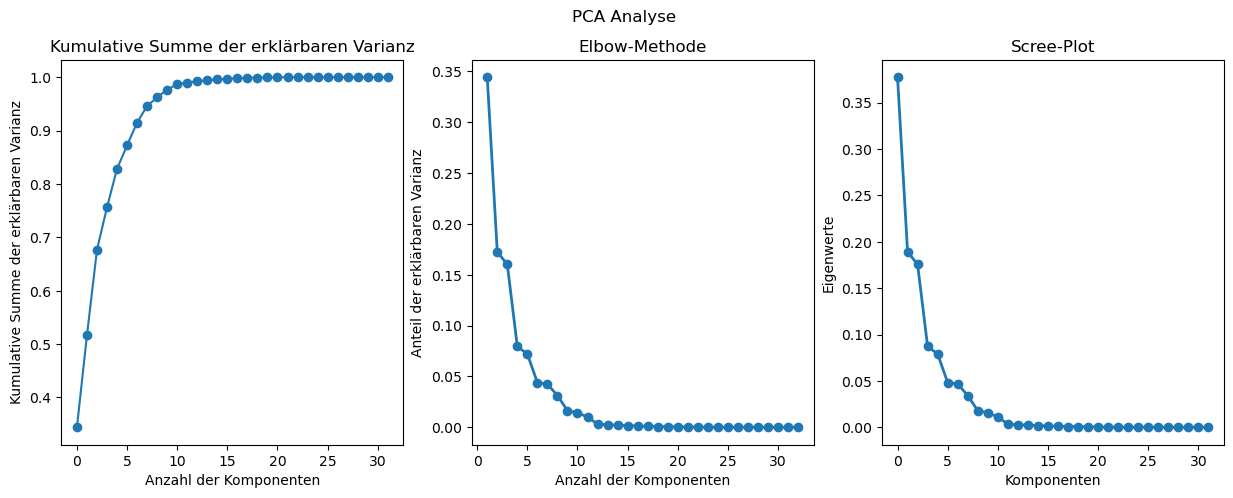

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot der Kumulativen Summe der erklärbaren Varianz
axs[0].plot(np.cumsum(pca.explained_variance_ratio_), '-o')
axs[0].set_xlabel('Anzahl der Komponenten')
axs[0].set_ylabel('Kumulative Summe der erklärbaren Varianz')
axs[0].set_title('Kumulative Summe der erklärbaren Varianz')

# Elbow-Methode
axs[1].plot(range(1,n+1), pca.explained_variance_ratio_, 'o-', linewidth=2)
axs[1].set_xlabel('Anzahl der Komponenten')
axs[1].set_ylabel('Anteil der erklärbaren Varianz')
axs[1].set_title('Elbow-Methode')

# Kaiser-Kriterium
eigenvalues = pca.explained_variance_
axs[2].plot(eigenvalues, 'o-', linewidth=2)
axs[2].set_xlabel('Komponenten')
axs[2].set_ylabel('Eigenwerte')
axs[2].set_title('Scree-Plot')

fig.suptitle('PCA Analyse')

plt.show()

Für die Kreuzvalidierung werden die "n"s ausgewählt, die im Bereich des "Ellbogen" liegen, also alle Werte von 2 bis 8.

In [37]:
n_components = range(2, 9)

# cross-validation
scores = []
for comp in tqdm(n_components):
    pca.n_components = comp
    pca_scores = cross_val_score(pca, df_onehot_scaled, cv=10)
    scores.append((comp, np.mean(pca_scores)))

print(scores)

100%|██████████| 7/7 [01:33<00:00, 13.43s/it]

[(2, 12.731284194230131), (3, 16.203593836857138), (4, 14.506694598939859), (5, 14.197829646124699), (6, 10.56960705564266), (7, 6.577734044511345), (8, 1.6001141467122886)]


Bei n = 3 wird das beste Ergebnis erzielt.

In [38]:
pca = PCA(n_components=3)
pca.fit(df_onehot_scaled)
transformed_data = pca.transform(df_onehot_scaled)

In [39]:
pca.components_.shape, len(df_onehot_scaled.columns)

((3, 32), 32)

Welche Features sind am wichtigsten für die 3 Hauptkomponenten?

/tmp/ipykernel_38495/3991135483.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs, rotation=90)


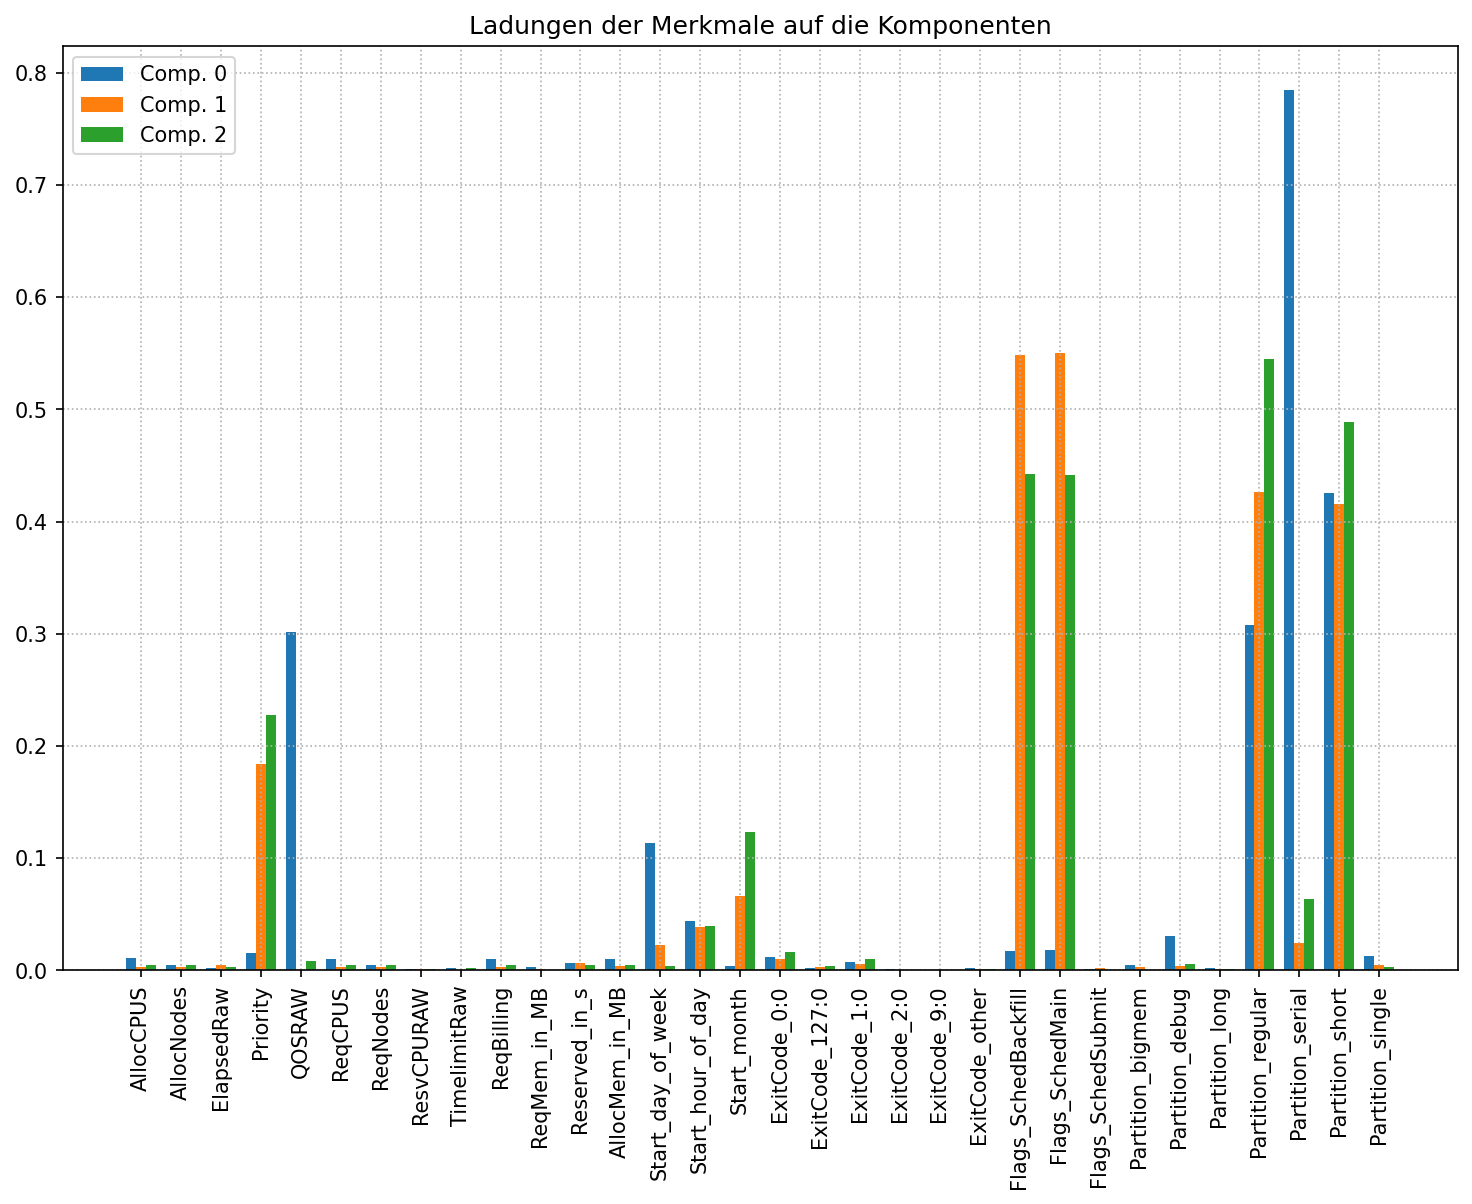

In [40]:
fig, ax = plt.subplots(figsize=(12,8), dpi=150)
x = np.arange(n)
width = 0.25
xlabs = df_onehot_scaled.columns
ax.bar(x-width, abs(pca.components_[0]), width=width, label='Comp. 0')
ax.bar(x,       abs(pca.components_[1]), width=width, label='Comp. 1')
ax.bar(x+width, abs(pca.components_[2]), width=width, label='Comp. 2')
ax.set_xticklabels(xlabs, rotation=90)
ax.set_xticks(x)
ax.set_title('Ladungen der Merkmale auf die Komponenten')
ax.grid(ls=':')
ax.legend()
plt.show()

Hieraus geht hervor, dass die Features Flags, Partition und Priority und QOSRAW den größten Einfluss auf die Hauptkomponenten haben. Somit sind dies die wichtigsten Features für die Hauptkomponenten. Dies kann sich später auch in den Clustern wiederspiegeln.

# 4 Clustering

100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


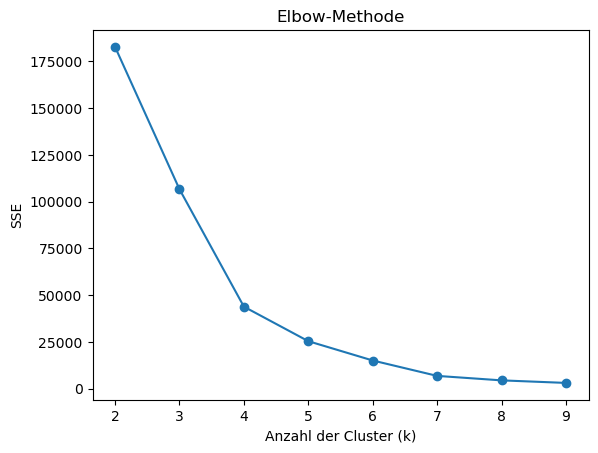

In [42]:
k_range = range(2, 10)

sse = []
for k in tqdm(k_range):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(transformed_data)
    sse.append(km.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('SSE')
plt.title('Elbow-Methode')
plt.show()

Aus dem Elbow-Plot geht hervor, dass die optimale Anzahl an Clustern gleich 4 ist. 

In [43]:
n_clus = 4
kmeans = KMeans(n_clusters=n_clus) 
kmeans.fit(transformed_data)


print(kmeans.labels_)

labels = np.array(kmeans.labels_)
df_slurm['Cluster'] = labels

[3 0 0 ... 0 2 2]


In [44]:
labels_char = df_slurm.Cluster.apply(lambda n: chr(ord('A') + n))
df_slurm['Cluster'] = labels_char
df_onehot['Cluster'] = labels_char

Text(0.5, 1.0, 'Clustergrößen')

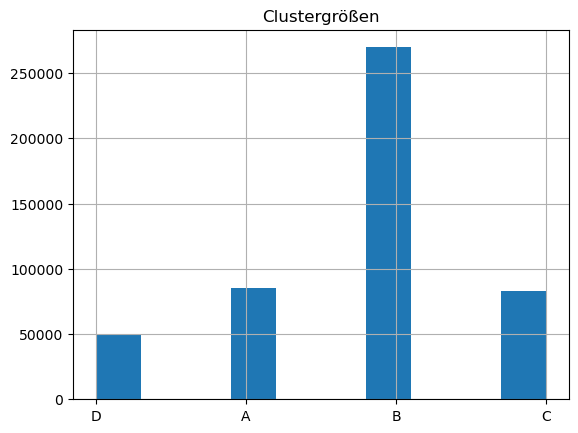

In [45]:
fig, ax = plt.subplots()
df_slurm.Cluster.hist(ax=ax)
ax.set_title('Clustergrößen')

# 5 Pipeline

Um verschiedene Methoden zu testen oder zukünftige Daten einzubeziehen wird eine effiziente Datenpipeline erstellt, die die vorher genannten Schritte etwas kompakter durchführt.

In [46]:
def preprocess_and_cluster_data(df, ncom=3, num_clusters=4, rs=100001):
    """
    df: Ein Pandas DataFrame mit den Daten.
    ncom: Die Anzahl der Komponenten der PCA.
    n_cluss: Die Anzahl der Cluster.
    """
    try:
        df_temp = df.drop(labels=['User', 'Account'], axis=1)
    except:
        df_temp = df
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns
    num_cols = df_temp.select_dtypes(exclude=['object', 'category']).columns
    
    column_transformer = ColumnTransformer(
        [('onehot', OneHotEncoder(sparse=False), cat_cols),
         ('scaler', MinMaxScaler(), num_cols)],
         remainder='passthrough'
    )

    pipeline = Pipeline([
        ('transformer', column_transformer),
        ('pca', PCA(n_components=ncom, random_state=rs)),
        ('kmeans', KMeans(n_clusters=num_clusters, random_state=rs))
    ])
    labels = np.array(pipeline.fit_predict(df_temp))
    df_temp['Cluster'] = labels
    df_temp['Cluster'] = df_temp.Cluster.apply(lambda n: chr(ord('A') + n))
    return df_temp

In [47]:
df_slurm_clustered = preprocess_and_cluster_data(df_slurm)

<AxesSubplot:>

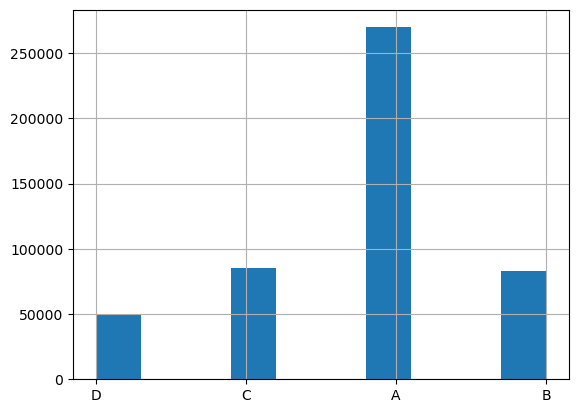

In [48]:
df_slurm_clustered.Cluster.hist()

Diese Abbildung zeigt die gleichen Clustergrößen wie bei der Clusterung ohne die Datenpipeline. Die Pipeline scheint also alle Schritte gleich auszuführen.

# 6 Export in eine CSV

In [49]:
df_slurm_clustered.to_csv(f"tweaked_datasets/slurm_dataset_clustered.csv")
df_onehot.to_csv(f"tweaked_datasets/slurm_dataset_onehot_clustered.csv")